# Clustering Geolocation Data Intelligently

In [121]:
import pandas as pd
import xml.etree.ElementTree as et

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive

from collections import defaultdict

import hdbscan
import folium
import re

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderQuotaExceeded
import time
import numpy as np


cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10


In [122]:

def parse_XML(xml_file, df_cols): 
    """Parse the input XML file and store the result in a pandas 
    DataFrame with the given columns. 
    
    The first element of df_cols is supposed to be the identifier 
    variable, which is an attribute of each node element in the 
    XML data; other features will be parsed from the text content 
    of each sub-element. 
    """
    
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    rows = []
    
    for node in xroot: 
        res = []
        for el in df_cols[0:]: 
            if node is not None and node.find(el) is not None:
                res.append(node.find(el).text)
            else: 
                res.append(None)
        rows.append({df_cols[i]: res[i] 
                     for i, _ in enumerate(df_cols)})
    
    out_df = pd.DataFrame(rows, columns=df_cols)
        
    return out_df

df = parse_XML("D://мусор/first_300_rows.xml",  ["FIO", "ADDRESS", "KVED", "STAN"])



In [70]:
geolocator = Nominatim(user_agent="my_geocoder")

def geocode_me(location):
    time.sleep(1.1)
    try:
        return geolocator.geocode(location)
    except (GeocoderTimedOut, GeocoderQuotaExceeded) as e:
        if GeocoderQuotaExceeded:
            print(e)
        else:
            print(f'Location not found: {e}')
            return None
        
df['zip_code'] = df['ADDRESS'].str.extract(r'\b(\d{5})\b') + " Україна"

df['location'] = df['zip_code'].apply(lambda x: geocode_me(x)) 

df['latitude'] = df['location'].apply(lambda x: x.latitude if x!= None else None)

df['longitude'] = df['location'].apply(lambda x: x.longitude if x!= None else None)


Service timed out
Service timed out
Service timed out


In [71]:
df[['FIO', 'ADDRESS', 'KVED', 'STAN', 'zip_code', 'longitude', 'latitude']]

,FIO,ADDRESS,KVED,STAN,zip_code,longitude,latitude
0,КОЛОС ОЛЕКСАНДР ОЛЕКСАНДРОВИЧ,"19821, ПРОВ. ФІЗКУЛЬТУРНИЙ, Б.8, С.БИРЛІВКА, Д...",52.12.0 РОЗДРІБНА ТОРГІВЛЯ В НЕСПЕЦІАЛІЗОВАНИХ...,припинено,19821 Україна,32.067265,50.069115
1,ДИМІЦЬКА ЛАРИСА ДМИТРІВНА,"19200, Черкаська обл., Жашківський район, міст...","52.27.1 РОЗДРІБНА ТОРГІВЛЯ МОЛОКОМ, МОЛОЧНИМИ ...",припинено,19200 Україна,30.103158,49.244889
2,ШЕРЕМЕТ ЄВГЕНІЙ ЮРІЙОВИЧ,"19715, ВУЛ. ГАГАРІНА, 11, С. ГЕЛЬМЯЗІВ, ЗОЛОТО...",52.44.2 РОЗДРІБНА ТОРГІВЛЯ ПОБУТОВИМИ ТОВАРАМИ,припинено,19715 Україна,31.836067,49.822301
3,ГЕРАСИМЕНКО ОЛЕНА АНАТОЛІЇВНА,"19744, ВУЛ. ЛЕНІНА, 3, 15, С. ПРИВІТНЕ, ЗОЛОТО...","52.42.1 РОЗДРІБНА ТОРГІВЛЯ ОДЯГОМ, ВКЛЮЧАЮЧИ С...",зареєстровано,19744 Україна,32.153166,49.815342
4,СТРИЖАК АНТОНІНА МИКОЛАЇВНА,"19723, ВУЛ. ГОРЬКОГО, 34, С. ПІЩАНЕ, ЗОЛОТОНІС...",52.11.0 РОЗДРІБНА ТОРГІВЛЯ В НЕСПЕЦІАЛІЗОВАНИХ...,припинено,19723 Україна,31.842782,49.745748
...,...,...,...,...,...,...,...
294,ВОДЯНИЦЬКА МАРИНА ВОЛОДИМИРІВНА,"20700, Черкаська обл., місто Сміла, ВУЛИЦЯ СТА...",52.62.2 РОЗДРІБНА ТОРГІВЛЯ НА РИНКАХ,припинено,20700 Україна,31.876739,49.219206
295,ТАРАНЕНКО ЛЮДМИЛА ВАСИЛІВНА,"20300, Черкаська обл., місто Умань, ВУЛИЦЯ ЧАП...",52.44.2 РОЗДРІБНА ТОРГІВЛЯ ПОБУТОВИМИ ТОВАРАМИ,припинено,20300 Україна,30.221854,48.760488
296,ЛІНЧЕВСЬКИЙ МИКОЛА ПИЛИПОВИЧ,"18008, ВУЛ.ХОМЕНКА, 30, КВ.65, М. ЧЕРКАСИ, ЧЕР...",52.62.2 РОЗДРІБНА ТОРГІВЛЯ НА РИНКАХ,припинено,18008 Україна,32.047849,49.427577
297,ГОМЕНЮК ВІКТОРІЯ ВАСИЛІВНА,"20034, ВУЛ.ПОЛЬОВА, 4, А, С.ОРАДІВКА, ХРИСТИНІ...",55.30.2 ДІЯЛЬНІСТЬ КАФЕ,припинено,20034 Україна,29.990892,48.771008


In [72]:
min_lat = 44.389078
max_lat = 52.349002
min_long = 22.144414
max_long = 40.213131  

df = df[df.latitude >= min_lat]
df = df[df.latitude <= max_lat]
df = df[df.longitude >= min_long]
df = df[df.longitude <= max_long]


In [73]:
df.duplicated(subset=['longitude','latitude']).values.any()

True

In [74]:
df.isna().values.any()

False

In [75]:
print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')
df.dropna(inplace=True)
df.drop_duplicates(subset=['longitude', 'latitude'], keep='first', inplace=True)
print(f'After dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

Before dropping NaNs and dupes	:	df.shape = (267, 8)
After dropping NaNs and dupes	:	df.shape = (102, 8)


In [76]:
df.head()

,FIO,ADDRESS,KVED,STAN,zip_code,location,latitude,longitude
0,КОЛОС ОЛЕКСАНДР ОЛЕКСАНДРОВИЧ,"19821, ПРОВ. ФІЗКУЛЬТУРНИЙ, Б.8, С.БИРЛІВКА, Д...",52.12.0 РОЗДРІБНА ТОРГІВЛЯ В НЕСПЕЦІАЛІЗОВАНИХ...,припинено,19821 Україна,"(Бирлівська сільська рада, Драбівський район, ...",50.069115,32.067265
1,ДИМІЦЬКА ЛАРИСА ДМИТРІВНА,"19200, Черкаська обл., Жашківський район, міст...","52.27.1 РОЗДРІБНА ТОРГІВЛЯ МОЛОКОМ, МОЛОЧНИМИ ...",припинено,19200 Україна,"(Жашків, Жашківський район, Черкаська область,...",49.244889,30.103158
2,ШЕРЕМЕТ ЄВГЕНІЙ ЮРІЙОВИЧ,"19715, ВУЛ. ГАГАРІНА, 11, С. ГЕЛЬМЯЗІВ, ЗОЛОТО...",52.44.2 РОЗДРІБНА ТОРГІВЛЯ ПОБУТОВИМИ ТОВАРАМИ,припинено,19715 Україна,"(19715, Україна, (49.8223009, 31.836067))",49.822301,31.836067
3,ГЕРАСИМЕНКО ОЛЕНА АНАТОЛІЇВНА,"19744, ВУЛ. ЛЕНІНА, 3, 15, С. ПРИВІТНЕ, ЗОЛОТО...","52.42.1 РОЗДРІБНА ТОРГІВЛЯ ОДЯГОМ, ВКЛЮЧАЮЧИ С...",зареєстровано,19744 Україна,"(Привітненська сільська рада, Золотоніський ра...",49.815342,32.153166
4,СТРИЖАК АНТОНІНА МИКОЛАЇВНА,"19723, ВУЛ. ГОРЬКОГО, 34, С. ПІЩАНЕ, ЗОЛОТОНІС...",52.11.0 РОЗДРІБНА ТОРГІВЛЯ В НЕСПЕЦІАЛІЗОВАНИХ...,припинено,19723 Україна,"(Піщанська сільська рада, Золотоніський район,...",49.745748,31.842782


In [77]:
X = np.array(df[['longitude', 'latitude']], dtype='float64')

In [78]:
X

array([[32.0672654 , 50.06911475],
       [30.10315768, 49.2448895 ],
       [31.836067  , 49.8223009 ],
       [32.15316593, 49.8153417 ],
       [31.842782  , 49.7457481 ],
       [31.611408  , 49.714127  ],
       [31.26333767, 49.705667  ],
       [31.9890591 , 49.8575864 ],
       [30.680849  , 49.134724  ],
       [30.988661  , 49.01722   ],
       [31.2718321 , 49.4871968 ],
       [30.35695903, 48.95092387],
       [30.70607387, 48.881505  ],
       [30.81610598, 48.86524176],
       [31.9254706 , 49.9354901 ],
       [32.302635  , 49.958569  ],
       [32.16122972, 49.96325645],
       [31.9129971 , 49.6769127 ],
       [31.55746146, 49.69796911],
       [30.8277476 , 49.2525981 ],
       [30.96304015, 49.07645405],
       [30.98808214, 48.98588886],
       [29.82015088, 48.96885643],
       [31.42599817, 49.2951606 ],
       [31.8715195 , 49.8498465 ],
       [32.0898349 , 49.04448825],
       [30.0224004 , 49.2002996 ],
       [31.81036043, 49.23481058],
       [31.234312  ,

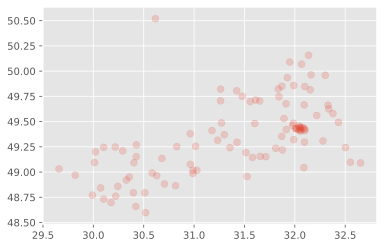

In [79]:
plt.scatter(X[:,0], X[:,1], alpha=0.2, s=50)

### Visualizing Grapchical Data

In [80]:
m = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=9, 
               tiles='Stamen Toner')

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        radius=5,
        popup=re.sub(r'[^a-zA-Z ]+', '', row.ADDRESS),
        color='#1787FE',
        fill=True,
        fill_colour='#1787FE'
    ).add_to(m)

In [81]:
m

# Clustering Strength / Perfomance metric

In [82]:
X_blobs, _ = make_blobs(n_samples=1000, centers=10, n_features=2,
                        cluster_std=0.5, random_state=4)

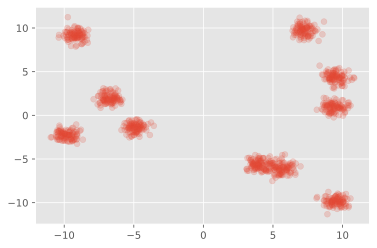

In [83]:
plt.scatter(X_blobs[:,0], X_blobs[:,1], alpha=0.2)

In [84]:
class_predictions = np.load('Data/sample_clusters.npy')

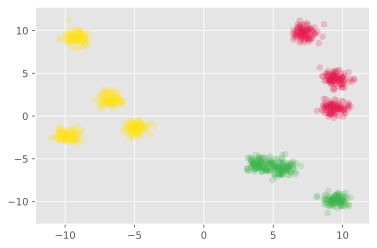

In [85]:
unique_clusters =np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster]) 

In [86]:
silhouette_score(X_blobs, class_predictions)

0.6657220862867241

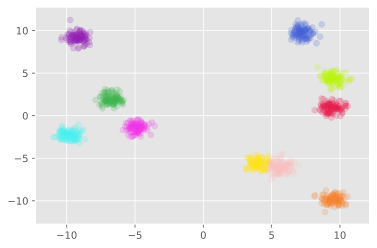

In [87]:
class_predictions = np.load('Data/sample_clusters_improved.npy')
unique_clusters =np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster]) 

In [88]:
silhouette_score(X_blobs, class_predictions)

0.7473587799908298

# K-means Clustering

In [89]:
X_blobs, _ = make_blobs(n_samples=1000, centers=50, 
                        n_features=2, cluster_std=1, random_state=4)

In [90]:
data = defaultdict(dict)
for x in range(1,21):
    model = KMeans(n_clusters=3, random_state=17, 
                   max_iter=x, n_init=1).fit(X_blobs)
    
    data[x]['class_predictions'] = model.predict(X_blobs)
    data[x]['centroids'] = model.cluster_centers_
    data[x]['unique_classes'] = np.unique(class_predictions)

In [91]:
def f(x):
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']

    for unique_class in unique_classes:
            plt.scatter(X_blobs[class_predictions==unique_class][:,0], 
                        X_blobs[class_predictions==unique_class][:,1], 
                        alpha=0.3, c=cols[unique_class])
    plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
    plt.ylim([-15,15]); plt.xlim([-15,15])
    plt.title('How K-Means Clusters')

interactive_plot = interactive(f, x=(1, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=10, description='x', max=20, min=1), Output(layout=Layout(height='350px'…

In [92]:
X = np.array(df[['longitude', 'latitude']], dtype='float64')
k = 70 
model = KMeans(n_clusters=k, random_state=17).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans{k}'] = class_predictions

In [93]:
df.head()

,FIO,ADDRESS,KVED,STAN,zip_code,location,latitude,longitude,CLUSTER_kmeans70
0,КОЛОС ОЛЕКСАНДР ОЛЕКСАНДРОВИЧ,"19821, ПРОВ. ФІЗКУЛЬТУРНИЙ, Б.8, С.БИРЛІВКА, Д...",52.12.0 РОЗДРІБНА ТОРГІВЛЯ В НЕСПЕЦІАЛІЗОВАНИХ...,припинено,19821 Україна,"(Бирлівська сільська рада, Драбівський район, ...",50.069115,32.067265,6
1,ДИМІЦЬКА ЛАРИСА ДМИТРІВНА,"19200, Черкаська обл., Жашківський район, міст...","52.27.1 РОЗДРІБНА ТОРГІВЛЯ МОЛОКОМ, МОЛОЧНИМИ ...",припинено,19200 Україна,"(Жашків, Жашківський район, Черкаська область,...",49.244889,30.103158,24
2,ШЕРЕМЕТ ЄВГЕНІЙ ЮРІЙОВИЧ,"19715, ВУЛ. ГАГАРІНА, 11, С. ГЕЛЬМЯЗІВ, ЗОЛОТО...",52.44.2 РОЗДРІБНА ТОРГІВЛЯ ПОБУТОВИМИ ТОВАРАМИ,припинено,19715 Україна,"(19715, Україна, (49.8223009, 31.836067))",49.822301,31.836067,25
3,ГЕРАСИМЕНКО ОЛЕНА АНАТОЛІЇВНА,"19744, ВУЛ. ЛЕНІНА, 3, 15, С. ПРИВІТНЕ, ЗОЛОТО...","52.42.1 РОЗДРІБНА ТОРГІВЛЯ ОДЯГОМ, ВКЛЮЧАЮЧИ С...",зареєстровано,19744 Україна,"(Привітненська сільська рада, Золотоніський ра...",49.815342,32.153166,32
4,СТРИЖАК АНТОНІНА МИКОЛАЇВНА,"19723, ВУЛ. ГОРЬКОГО, 34, С. ПІЩАНЕ, ЗОЛОТОНІС...",52.11.0 РОЗДРІБНА ТОРГІВЛЯ В НЕСПЕЦІАЛІЗОВАНИХ...,припинено,19723 Україна,"(Піщанська сільська рада, Золотоніський район,...",49.745748,31.842782,66


In [96]:
def create_map(df, cluster_column):

    m = folium.Map(location=[df.latitude.mean(), df.longitude.mean()],
                   zoom_start=9, tiles='Stamen Toner')

    for _, row in df.iterrows():
        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location= [row['latitude'], row['longitude']],
            radius=5,
            popup= row[cluster_column],
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
    return m

m = create_map(df, 'CLUSTER_kmeans70')
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('kmeans_70.html')

K=70
Silhouette Score: 0.20874323461800087


In [97]:
m

In [98]:
best_silhouette, best_k = -1, 0

for k in tqdm(range(2, 100)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
        
print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}') 

100%|██████████| 98/98 [00:12<00:00,  7.64it/s]

K=2
Silhouette Score: 0.6275777533241262


# DBSCAN

### Density-Based Spatial Clustering of Applications with Noise

In [99]:
# code for indexing out certain values
dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1])
new = np.array([(counter+2)*x if x ==-1 else x for counter, x in enumerate(dummy)])

In [100]:
model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions= model.labels_

df['CLUSTERS_DBSCAN'] = class_predictions

In [104]:
m = create_map(df, 'CLUSTERS_DBSCAN')


In [105]:
m

# HDBSCAN
## Hierarchial DBSCAN

In [106]:
model = hdbscan.HDBSCAN(min_cluster_size=5,min_samples=2, 
                        cluster_selection_epsilon=0.01)
class_predictions = model.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions

In [107]:

print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

m

Number of clusters found: 6
Number of outliers found: 16
Silhouette ignoring outliers: 0.33639608845608804
Silhouette outliers as singletons: -0.02227013206107612


# Addresing outliers

In [109]:
classifier = KNeighborsClassifier(n_neighbors=1)

In [110]:
df_train = df[df.CLUSTER_HDBSCAN!=-1]
df_predict = df[df.CLUSTER_HDBSCAN==-1]

In [112]:
X_train = np.array(df_train[['longitude', 'latitude']], dtype='float64')
Y_train = np.array(df_train[['CLUSTER_HDBSCAN']])

X_predict = np.array(df_predict[['longitude', 'latitude']], dtype='float64')

In [113]:
classifier.fit(X_train, Y_train)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [114]:
predictions = classifier.predict(X_predict)

In [115]:
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN']

In [116]:
df.loc[df.CLUSTER_HDBSCAN==-1,'CLUSTER_hybrid'] = predictions

In [117]:
m = create_map(df, 'CLUSTER_hybrid')

In [118]:
m

In [119]:
class_predictions = df.CLUSTER_hybrid
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')

Number of clusters found: 6
Silhouette: 0.33435695998447995


Text(0.5, 0, 'Cluster Sizes')

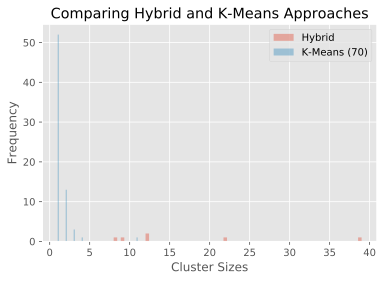

In [120]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=70, alpha=0.4,
                                              label='Hybrid')
df['CLUSTER_kmeans70'].value_counts().plot.hist(bins=70, alpha=0.4,
                                             label='K-Means (70)')
plt.legend()
plt.title('Comparing Hybrid and K-Means Approaches')
plt.xlabel('Cluster Sizes')